# Publication "Multi-Armed Bandits: Epsilon-Greedy Algorithm with Python Code" (medium.com)

In [1]:
import uuid
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from typing import List, Tuple
from collections import defaultdict
import logging

In [2]:
class Bandit:
    def __init__(self, m):
        """
        Simulates bandit.
        Args:
            m (float): True mean.
        """

        self.m = m
        self.id = uuid.uuid4()

    def pull(self):
        """
        Simulate pulling the arm of the bandit.
        Normal distribution with mu = self.m and sigma = 1.
        """
        reward = np.random.randn() + self.m

        return reward

In [3]:
class BanditRewardsLog:
    def __init__(self):
        self.total_actions = 0
        self.total_rewards = 0
        self.all_rewards = []
        self.record = defaultdict(lambda: dict(actions=0, reward=0))

    def record_action(self, bandit, reward):
        self.total_actions += 1
        self.total_rewards += reward
        self.all_rewards.append(reward)
        self.record[bandit.id]['actions'] += 1
        self.record[bandit.id]['reward'] += reward

    def __getitem__(self, bandit):
        return self.record[bandit.id]

In [4]:
class EpsilonGreedyAgent:
    def __init__(self, bandits: List[Bandit], epsilon: float = None):
        self.bandits = bandits
        self.epsilon = epsilon
        self.rewards_log = BanditRewardsLog()

    def _get_random_bandit(self) -> Bandit:
        return np.random.choice(self.bandits)

    def _get_current_best_bandit(self) -> Bandit:
        estimates = []
        for bandit in self.bandits:
            bandit_record = self.rewards_log[bandit]
            if not bandit_record['actions']:
                estimates.append(0)
            else:
                estimates.append(bandit_record['reward'] / bandit_record['actions'])

        return self.bandits[np.argmax(estimates)]

    def _choose_bandit(self) -> Bandit:
        epsilon = self.epsilon or 1 / (1 + self.rewards_log.total_actions)

        p = np.random.uniform(0, 1, 1)
        if p < epsilon:
            bandit = self._get_random_bandit()
        else:
            bandit = self._get_current_best_bandit()

        return bandit

    def take_action(self):
        current_bandit = self._choose_bandit()
        reward = current_bandit.pull()
        self.rewards_log.record_action(current_bandit, reward)
        return reward

    def take_actions(self, iter):
        for _ in range(iter):
            self.take_action()

In [5]:
logger = logging.getLogger('logger')

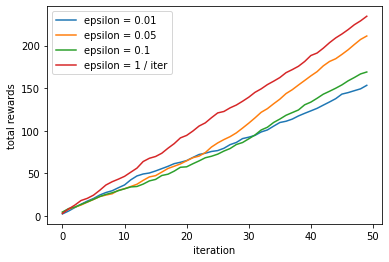

In [6]:
def compare_epsilons(
    epsilons: List[float],
    bandits_true_means: List[float],
    iterations: int,
) -> Tuple[List[EpsilonGreedyAgent], List[float]]:
    """
    Compare different epsilons for epsilon-greedy algorithm.
    """
    agents = []
    bandits = [Bandit(m) for m in bandits_true_means]

    for epsilon in epsilons:
        logger.info("Running epsilon-greedy for epsilon = %f", epsilon)
        agent = EpsilonGreedyAgent(bandits=bandits, epsilon=epsilon)
        agent.take_actions(iterations)
        agents.append(agent)

    return agents, epsilons
  
  
epsilons = [0.01, 0.05, 0.1, None]
bandits_means = [3, 4, 5]

iterations = 50
agents, _ =  compare_epsilons(epsilons, bandits_means, iterations)

all_rewards = [agent.rewards_log.all_rewards for agent in agents]


for i in range(len(agents)):
    plt.plot(
        np.cumsum(all_rewards[i]), 
        label="epsilon = {}".format(epsilons[i] or '1 / iter'),
    )

plt.xlabel("iteration")
plt.ylabel("total rewards")
plt.legend()
plt.show()